### Churn Prediction Project (Classification)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import urllib.request

#url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
file_path = "../data/Telco-Customer-Churn.csv"

#urllib.request.urlretrieve(url, file_path)

In [3]:
df = pd.read_csv(file_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [210]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [211]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

In [212]:
df.churn.head()

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object

In [213]:
df.churn = (df.churn == 'yes').astype(int)

### Setting up the validation framework

In [214]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [215]:
len(df_full_train), len(df_test)

(5634, 1409)

In [216]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [217]:
len(df_train), len(df_val)

(4225, 1409)

In [218]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [219]:
df_train.totalcharges

3897    8425.15
1980    1021.55
6302     413.65
727      356.10
5104     370.50
         ...   
3774    4079.55
6108     476.80
1530     190.05
3701     761.95
4368     751.65
Name: totalcharges, Length: 4225, dtype: float64

### EDA

* Check missing values
* Look at the target variable (churn)
* Look at numerical and categorical variables

In [220]:
df_full_train.isnull().sum() 

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [221]:
df_full_train.reset_index(drop=True, inplace=True)

In [222]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [223]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int32
dtype: object

### Feature importance: Churn rate and risk ratio

In [224]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [225]:
categorical = categorical_columns.copy()
categorical.remove('customerid')
categorical.remove('churn')
categorical.remove('totalcharges')
categorical.append('seniorcitizen')

In [226]:
df_full_train[categorical].nunique()

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
seniorcitizen       2
dtype: int64

### Churn Rate

In [227]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

0.2632135306553911

In [228]:
global_churn = df_full_train.churn.mean()
global_churn

0.26996805111821087

In [229]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [230]:
churn_partner = df_full_train[df_full_train.partner == 'yes']['churn'].mean()
churn_partner

0.20503330866025166

In [231]:
churn_no_partner = df_full_train[df_full_train.partner == 'no']['churn'].mean()
churn_no_partner

0.3298090040927694

In [232]:
global_churn - churn_partner, global_churn - churn_no_partner

(0.06493474245795922, -0.05984095297455855)

### Risk Ratio

In [233]:
churn_partner/global_churn

0.7594724924338315

In [234]:
churn_no_partner/global_churn

1.2216593879412643

In [235]:
for category in categorical:
    print(category)
    df_group = df_full_train.groupby(category)['churn'].agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print("\n\n")

gender


,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980





partner


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472





dependents


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651





phoneservice


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412





multiplelines


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948





internetservice


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201





onlinesecurity


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570





onlinebackup


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660





deviceprotection


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480





techsupport


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390





streamingtv


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328





streamingmovies


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182





contract


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730





paperlessbilling


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560





paymentmethod


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121





seniorcitizen


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


### Feature importance: Mutual information

In [236]:
from sklearn.metrics import mutual_info_score

In [237]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [238]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [239]:
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

### Feature importance: Correlation

In [240]:
df_full_train[numerical].corrwith(df_full_train['churn']).abs()

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

In [241]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5953420669577875

In [242]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

0.3994413407821229

In [243]:
df_full_train[df_full_train.tenure > 12].churn.mean()

0.17634908339788277

In [244]:
df_full_train[df_full_train.monthlycharges <= 20 ].churn.mean()

0.08795411089866156

In [245]:
df_full_train[(df_full_train.monthlycharges > 20) & (df_full_train.monthlycharges <= 50)].churn.mean()

0.18340943683409436

In [246]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()

0.32499341585462205

### One Hot encoding

* Use Scikit-learn to encode categorical features

In [247]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

In [248]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

In [249]:
X_train = dv.fit_transform(train_dicts)

In [250]:
dv.feature_names_

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

In [251]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

In [252]:
X_val = dv.transform(val_dicts)

### Logistic Regression
* Binary Regression
* Logistic vs Linear Regression

In [253]:
def sigmoid(z:np.ndarray)->np.ndarray:
    return 1 / (1 + np.exp(-z))

In [254]:
z = np.linspace(-7, 7, 51)

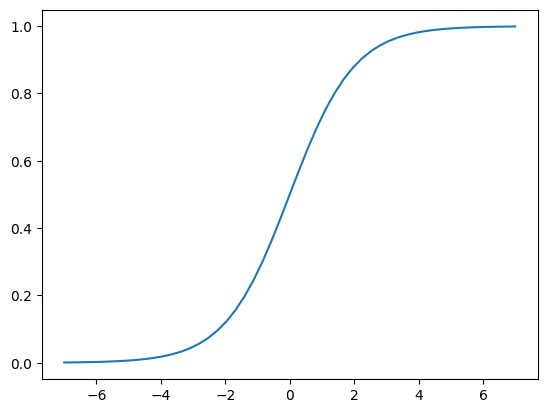

In [255]:
plt.plot(z, sigmoid(z))

In [256]:
def dot(X: np.ndarray, W: np.ndarray, b)->np.ndarray:
    n = len(X)
    result = []
    for i in range(n):
        res = 0.0
        for j in range(X.shape[1]):
            res += X[i][j] * W[j]
        result.append(res)
    return np.array(result)

def logistic_regression(X:np.ndarray, W:np.ndarray, b:float)->np.ndarray:
    z = dot(X, W) + b
    return sigmoid(z)

### Train logistic regression with Scikit-Learn

In [257]:
from sklearn.linear_model import LogisticRegression

In [258]:
X_val

array([[0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0000e+00, 7.1000e+01,
        4.9734e+03],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        2.0750e+01],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        2.0350e+01],
       ...,
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.8000e+01,
        1.0581e+03],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        9.3300e+01],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 3.0000e+00,
        2.9285e+02]])

In [259]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [260]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.142,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.123, -0.166,  0.059, -0.087, -0.032,  0.07 , -0.059,  0.142,
       -0.249,  0.216, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [261]:
model.intercept_[0]

-0.10901362161842161

In [262]:
# Probability of the positive class
y_pred =  model.predict_proba(X_val)[:, 1]

In [263]:
y_pred

array([0.00900304, 0.20470486, 0.21236512, ..., 0.13643964, 0.79979009,
       0.83743433])

In [264]:
churn_decision = (y_pred >= 0.5)

In [265]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

In [266]:
(y_val == churn_decision).mean()

0.8034066713981547

In [267]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [268]:
df_pred

,probability,prediction,actual,correct
0,0.009003,0,0,True
1,0.204705,0,0,True
2,0.212365,0,0,True
3,0.542958,1,1,True
4,0.213888,0,0,True
...,...,...,...,...
1404,0.314074,0,0,True
1405,0.039389,0,1,False
1406,0.136440,0,0,True
1407,0.799790,1,1,True


### Model Interpretation

In [269]:
dict(zip(dv.get_feature_names_out(), model.coef_[0]))

{'contract=month-to-month': 0.4752822353689039,
 'contract=one_year': -0.17492781344844333,
 'contract=two_year': -0.4080105773159458,
 'dependents=no': -0.029808379905047686,
 'dependents=yes': -0.07784777549781707,
 'deviceprotection=no': 0.06263888593514491,
 'deviceprotection=no_internet_service': -0.0889297869549433,
 'deviceprotection=yes': -0.08136525438406535,
 'gender=female': -0.0342858771094076,
 'gender=male': -0.07337027829262355,
 'internetservice=dsl': -0.33538666133810424,
 'internetservice=fiber_optic': 0.3166602928944309,
 'internetservice=no': -0.0889297869549433,
 'monthlycharges': 0.0036753312028911986,
 'multiplelines=no': -0.2581196546789575,
 'multiplelines=no_phone_service': 0.14164186110457597,
 'multiplelines=yes': 0.00882163817346087,
 'onlinebackup=no': 0.06250070360950107,
 'onlinebackup=no_internet_service': -0.0889297869549433,
 'onlinebackup=yes': -0.08122707205754996,
 'onlinesecurity=no': 0.26560366419890813,
 'onlinesecurity=no_internet_service': -0.

In [270]:
small = ['contract', 'tenure', 'monthlycharges']

df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [271]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')


In [272]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [273]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [274]:
x_train_small = dv_small.transform(dicts_train_small)

In [275]:
lr = LogisticRegression()
lr.fit(x_train_small, y_train)

LogisticRegression()

In [276]:
b = lr.intercept_[0]
b

-2.477957596325319

In [277]:
W = lr.coef_[0]
W

array([ 0.9711394 , -0.02379507, -0.94828863,  0.02748534, -0.03619005])

In [278]:
dict(zip(dv_small.get_feature_names_out(), W.round(3)))

{'contract=month-to-month': 0.971,
 'contract=one_year': -0.024,
 'contract=two_year': -0.948,
 'monthlycharges': 0.027,
 'tenure': -0.036}

Understanding how the weights and bias values affect the score,
    we take the values from the cell and sum them up manually

In [279]:
''' If User has a month-to-month contract then one_year and two_year have values of 0 respectively.
    The user also pays monthly charge of $50 and a tenure of 5 years'''


z = -2.47 + (1 *1.063) + (50 * 0.027) + (5 * -0.036)
z


-0.23700000000000015

In [280]:
sigmoid(z)

0.4410257854815464

##### The probability of the customer churning is below 0.5 which can be categorized as False

### Using the model

In [281]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [282]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [283]:
y_full_train = df_full_train['churn'].values

In [284]:
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

LogisticRegression()

In [285]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [286]:
X_test = dv.transform(dicts_test)

In [287]:
y_pred = model.predict_proba(X_test)[:, 1]

In [288]:
churn_decision = (y_pred >= 0.5)
(churn_decision == y_test).mean()

0.8126330731014905

In [289]:
customer_data = dicts_test[-1]

In [290]:
X_customer = dv.transform([customer_data])
y_cust_pred = model.predict_proba(X_customer)[0, 1]
print(f"The predicted probability this customer is going to churn {(y_cust_pred >= 0.5).astype(int)}, The actual value of the customer {y_test[-1]}")

The predicted probability this customer is going to churn 1, The actual value of the customer 1


In [291]:
(model.predict_proba(dv.transform(dicts_test[0]))[0, 1]) >= 0.5

False

In [292]:
y_test[0]

0